https://github.com/process-intelligence-solutions/pm4py/blob/release/notebooks/1_event_data.ipynb

# Importok

In [ ]:
import pandas as pd
import pm4py
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
import pm4py.statistics.traces.generic.log.case_statistics as case_statistics
from pm4py.util import constants
from pm4py.visualization.graphs import visualizer as graphs_visualizer
from pm4py.algo.filtering.log.attributes import attributes_filter
import pm4py.statistics.sojourn_time as stl
from pm4py.visualization.dfg import visualizer as dfg_visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from tqdm import tqdm
import csv
import os

# Fájl beolvasása

In [5]:
pd_log = pd.read_csv("4_PMD_Car_Insurance_Claims_Event_Log_1.0.0.csv", sep=",")

In [6]:
pd_log.head()

,Claim ID,Event,Timestamp,Channel,User Name,Claim Type,Damage Type,Accident Location,Car Model,Claim Amount,NPS
0,CLAIM0001,Claim Registration,08/08/2022 07:32:23,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral
1,CLAIM0001,Document Verification,08/08/2022 12:32:23,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral
2,CLAIM0001,Missing Documentation,09/08/2022 00:32:23,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral
3,CLAIM0001,Document Verification,09/08/2022 02:32:23,Office,CWHITE,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral
4,CLAIM0001,Claim Settlement,09/08/2022 14:32:23,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral


A Claim ID használható egyedi azonosítóként, az Event az esemény típusa, a Timestamp pedig az esemény időpontja. A User Name a folyamat által használt erőforrás.

# Átalakítások sorba rendezéshez és xes formátumhoz

In [7]:
pd_log["claim_id"] = pd_log["Claim ID"].str.replace("CLAIM", "", regex=False).astype(int)
pd_log["activity_key"] = pd_log["Event"]
pd_log["timestamp_key"] = pd.to_datetime(pd_log["Timestamp"], format="%d/%m/%Y %H:%M:%S")
pd_log["org:resource"] = pd_log["User Name"]
pd_log["case_id"] = pd_log["Claim ID"]

In [8]:
pd_log = pd_log.sort_values(by=["claim_id","timestamp_key"])
pd_log = pd_log.reset_index(drop=True)

In [9]:
pd_log.head()

,Claim ID,Event,Timestamp,Channel,User Name,Claim Type,Damage Type,Accident Location,Car Model,Claim Amount,NPS,claim_id,activity_key,timestamp_key,org:resource,case_id
0,CLAIM0001,Claim Registration,08/08/2022 07:32:23,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral,1,Claim Registration,2022-08-08 07:32:23,AROBINSON,CLAIM0001
1,CLAIM0001,Document Verification,08/08/2022 12:32:23,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral,1,Document Verification,2022-08-08 12:32:23,LCLARK,CLAIM0001
2,CLAIM0001,Missing Documentation,09/08/2022 00:32:23,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral,1,Missing Documentation,2022-08-09 00:32:23,AROBINSON,CLAIM0001
3,CLAIM0001,Document Verification,09/08/2022 02:32:23,Office,CWHITE,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral,1,Document Verification,2022-08-09 02:32:23,CWHITE,CLAIM0001
4,CLAIM0001,Claim Settlement,09/08/2022 14:32:23,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,Neutral,1,Claim Settlement,2022-08-09 14:32:23,LCLARK,CLAIM0001


In [10]:
log = pm4py.format_dataframe(pd_log, 
                             case_id="case_id",
                             activity_key="activity_key", 
                             timestamp_key="timestamp_key",
                             timest_format="%d/%m/%Y %H:%M:%S")

In [11]:
log.head()

,Claim ID,Event,Timestamp,Channel,User Name,Claim Type,Damage Type,Accident Location,Car Model,Claim Amount,...,claim_id,activity_key,timestamp_key,org:resource,case_id,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,CLAIM0001,Claim Registration,2022-08-08 07:32:23+00:00,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,1,Claim Registration,2022-08-08 07:32:23+00:00,AROBINSON,CLAIM0001,CLAIM0001,Claim Registration,2022-08-08 07:32:23+00:00,0,0
1,CLAIM0001,Document Verification,2022-08-08 12:32:23+00:00,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,1,Document Verification,2022-08-08 12:32:23+00:00,LCLARK,CLAIM0001,CLAIM0001,Document Verification,2022-08-08 12:32:23+00:00,1,0
2,CLAIM0001,Missing Documentation,2022-08-09 00:32:23+00:00,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,1,Missing Documentation,2022-08-09 00:32:23+00:00,AROBINSON,CLAIM0001,CLAIM0001,Missing Documentation,2022-08-09 00:32:23+00:00,2,0
3,CLAIM0001,Document Verification,2022-08-09 02:32:23+00:00,Office,CWHITE,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,1,Document Verification,2022-08-09 02:32:23+00:00,CWHITE,CLAIM0001,CLAIM0001,Document Verification,2022-08-09 02:32:23+00:00,3,0
4,CLAIM0001,Claim Settlement,2022-08-09 14:32:23+00:00,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,1,Claim Settlement,2022-08-09 14:32:23+00:00,LCLARK,CLAIM0001,CLAIM0001,Claim Settlement,2022-08-09 14:32:23+00:00,4,0


# Az adatok vizsgálta, hogy helyesek voltak-e az átalakítások

In [12]:
pm4py.get_start_activities(log)

{'Claim Registration': 49873}

In [13]:
pm4py.get_end_activities(log)


{'Post-Claim Review': 49873}

In [14]:
pm4py.get_event_attribute_values(log,"org:resource")

{'RPA': 67058,
 'TMOORE': 50253,
 'LCLARK': 49883,
 'CWHITE': 40837,
 'RWALKER': 33929,
 'AROBINSON': 33401,
 'JSMITH': 29978,
 'CJONES': 29545,
 'GCLARK': 25333,
 'BTHOMPSON': 19367,
 'JDOE': 17977,
 'MWHITE': 14957,
 'DHARRIS': 13118,
 'MKING': 12273,
 'NLEWIS': 3641}

In [15]:
pm4py.get_event_attribute_values(log,"concept:name")

{'Claim Settlement': 59630,
 'Document Verification': 56482,
 'Claim Registration': 49873,
 'Case closure': 49873,
 'Post-Claim Review': 49873,
 'Claim Approval': 46912,
 'Vehicle Repair': 36383,
 'Final Documentation': 36383,
 'Fraud Investigation': 11002,
 'Total Loss Settlement': 9029,
 'Set Reserves': 7523,
 'Payment Sent': 7523,
 'Missing Documentation': 6609,
 'Claim Rejection': 5967,
 'Claim Subrogation': 5482,
 'Claim Appeal': 3006}

In [16]:
min_date = log["Timestamp"].min()
max_date = log["Timestamp"].max()
delta = pd.Timedelta(max_date-min_date)
print(min_date, max_date, delta)

2022-01-01 01:25:28+00:00 2024-01-03 16:48:06+00:00 732 days 15:22:38


Az adathalmaz időszaka 01/01/2022 to 31/12/2023 így a fenti adatok jónak tűnnek.

# Exportálás xes formátumban

In [17]:
xes_exporter.apply(log,'4_PMD_Car_Insurance_Claims_Event_Log_1.0.0.xes')

/Users/tothi/pysrc/pemik/fmesfb/beadando/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 49873/49873 [00:22<00:00, 2186.73it/s]


# Adatok statisztikái

## Event átlagos hosszának vizsgálata

In [18]:
parameters = {stl.log.get.Parameters.START_TIMESTAMP_KEY:'time:timestamp'}
stl.log.get.apply(log, parameters)

{'Claim Registration': 0.0,
 'Document Verification': 0.0,
 'Missing Documentation': 0.0,
 'Claim Settlement': 0.0,
 'Claim Approval': 0.0,
 'Vehicle Repair': 0.0,
 'Final Documentation': 0.0,
 'Case closure': 0.0,
 'Post-Claim Review': 0.0,
 'Fraud Investigation': 0.0,
 'Total Loss Settlement': 0.0,
 'Set Reserves': 0.0,
 'Payment Sent': 0.0,
 'Claim Subrogation': 0.0,
 'Claim Rejection': 0.0,
 'Claim Appeal': 0.0}

Mivel csak egy időpont van és nem start és end időppontok ezért 0 mindegyik.

## Case duration vizsgálata

In [19]:
mcd = case_statistics.get_median_case_duration(log, parameters={"timestamp_key": "time:timestamp"})
print(mcd, mcd / 60 / 60 / 24)

118920.0 1.3763888888888889


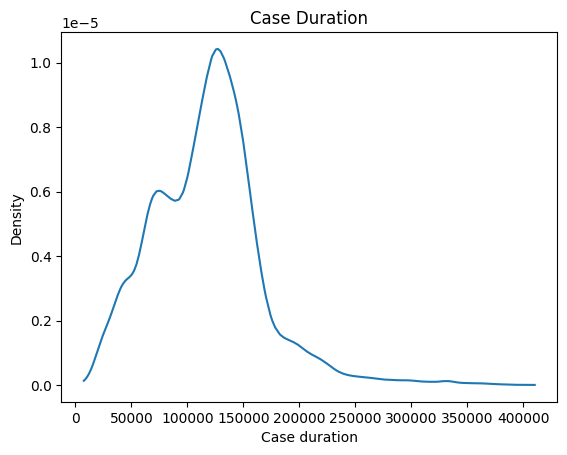

In [20]:
parameters = {constants.PARAMETER_CONSTANT_TIMESTAMP_KEY:"timestamp_key"}
x,y = case_statistics.get_kde_caseduration(log,parameters=parameters)
gviz = graphs_visualizer.apply_plot(x,y,variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

## Események időbeli eloszlásának vizsgálata

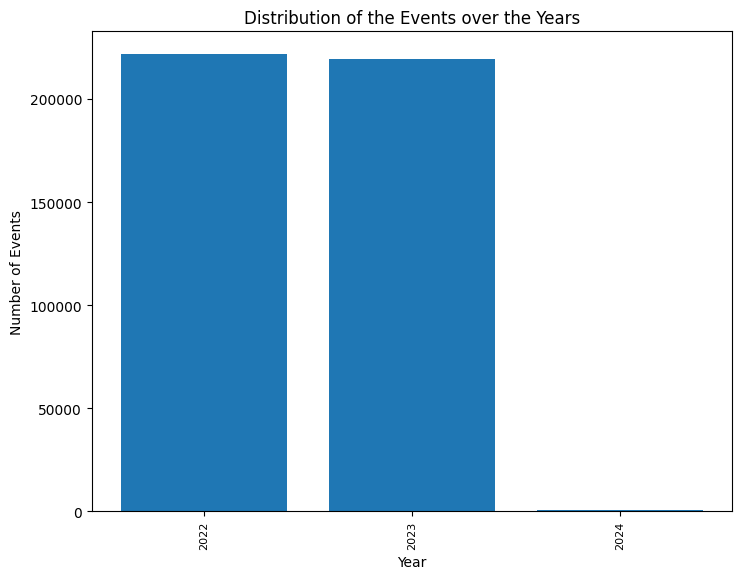

In [21]:
d_type = "years"
pm4py.view_events_distribution_graph(log, distr_type=d_type, format="png")

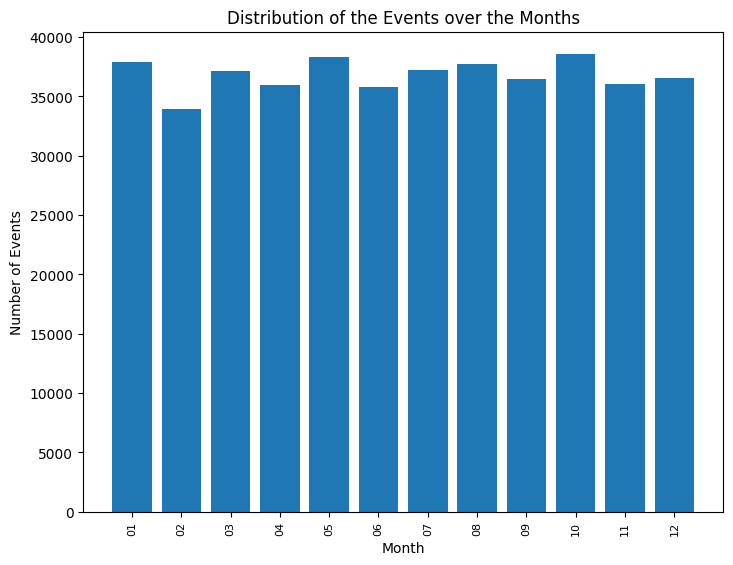

In [22]:
d_type = "months"
pm4py.view_events_distribution_graph(log, distr_type=d_type, format="png")

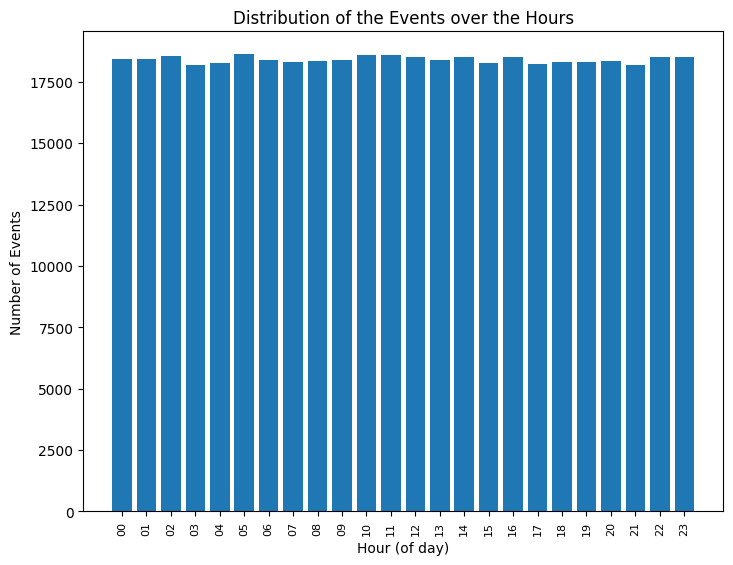

In [23]:
d_type = "hours"
pm4py.view_events_distribution_graph(log, distr_type=d_type, format="png")

## Az eseményekben résztvevő resource-ok vizsgálata

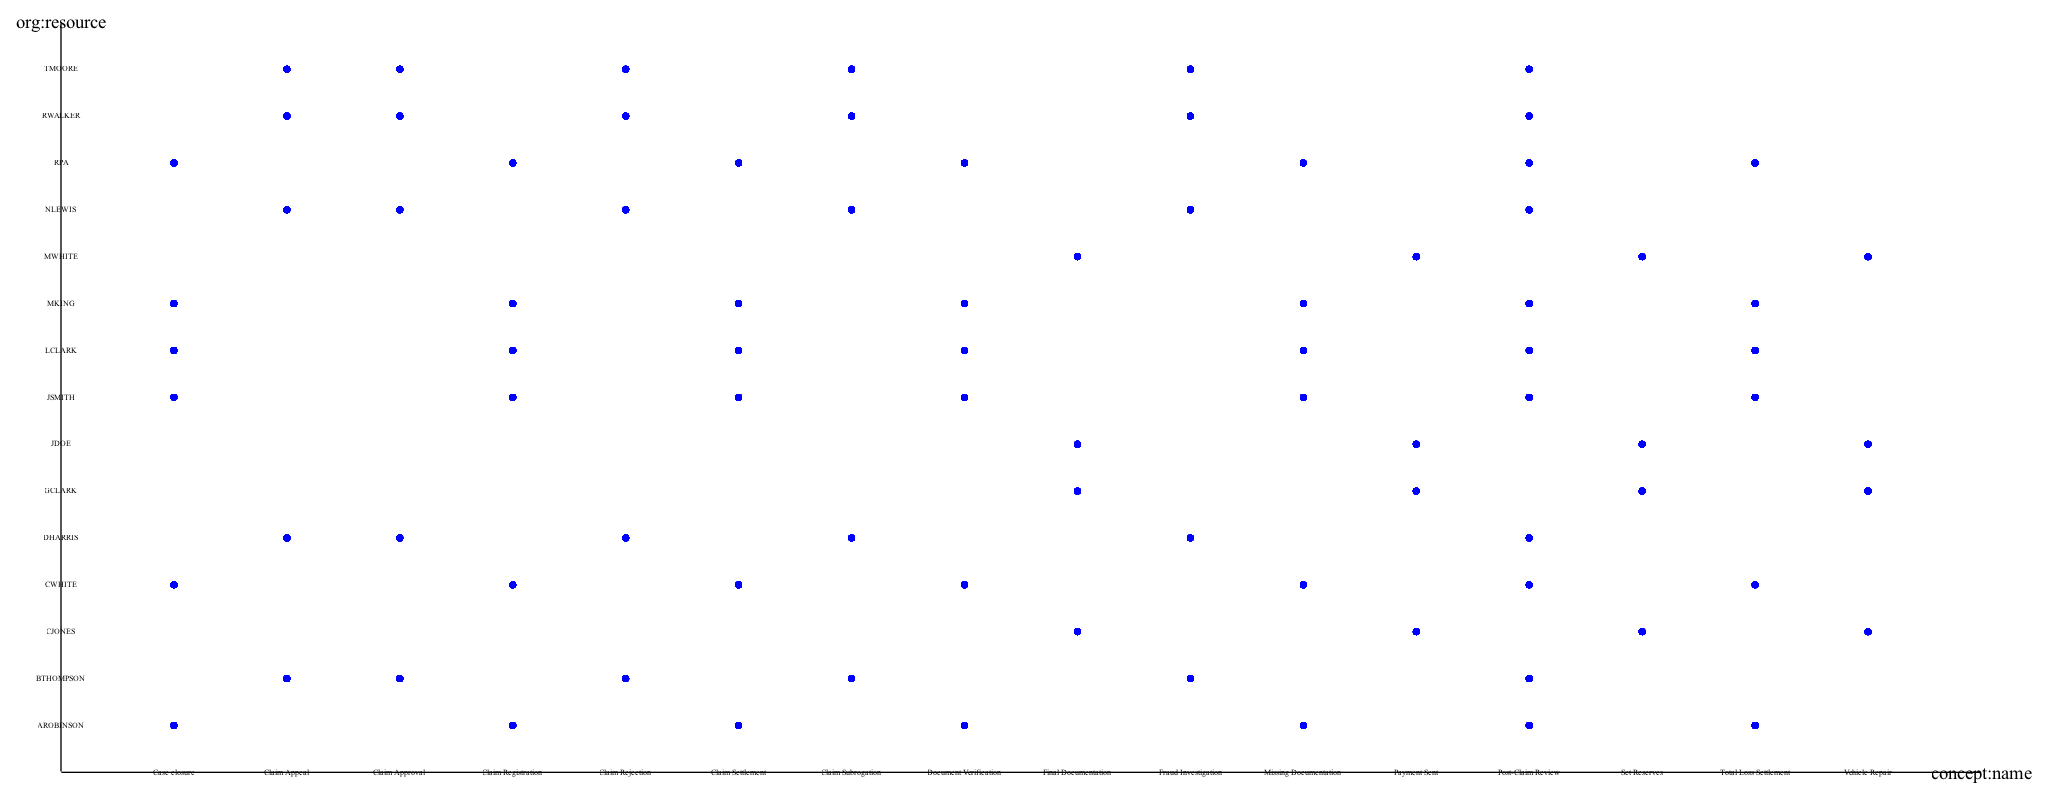

In [24]:
pm4py.view_dotted_chart(log, format='png', attributes=['concept:name','org:resource'])

# Directly Folows Graph

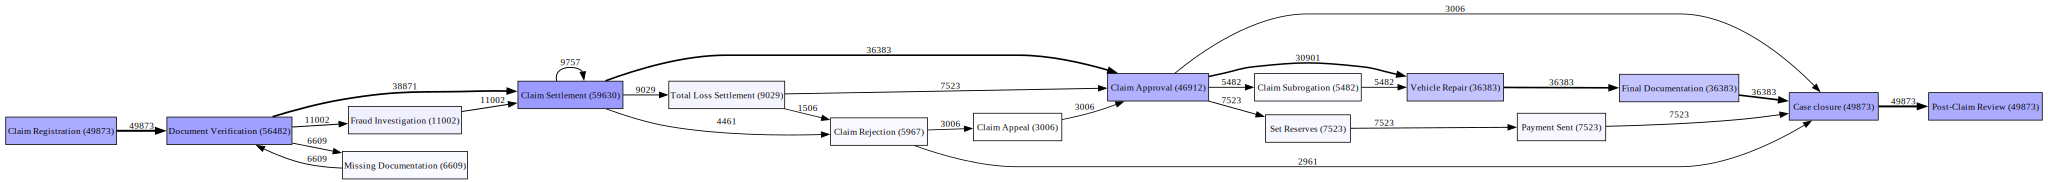

In [25]:
dfg = dfg_discovery.apply(log)
dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)

## Heatmap

In [26]:
fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
df = dict(fp_log['dfg'])
activities = list(fp_log['activities'])
df_mtx = pd.DataFrame(columns=activities,index=activities)
df_mtx = df_mtx.fillna(0)

df_keys = list(df.keys())
for key in df_keys:
    i = key[0]
    j = key[1]
    df_mtx.at[i,j] = df[(i,j)]

df_mtx

/var/folders/p9/yfdwydy169s3mz1hd23bwrtw0000gn/T/ipykernel_96135/3373190168.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mtx = df_mtx.fillna(0)


,Total Loss Settlement,Case closure,Vehicle Repair,Post-Claim Review,Set Reserves,Claim Appeal,Missing Documentation,Document Verification,Claim Registration,Claim Approval,Claim Settlement,Final Documentation,Claim Subrogation,Claim Rejection,Payment Sent,Fraud Investigation
Total Loss Settlement,0,0,0,0,0,0,0,0,0,7523,0,0,0,1506,0,0
Case closure,0,0,0,49873,0,0,0,0,0,0,0,0,0,0,0,0
Vehicle Repair,0,0,0,0,0,0,0,0,0,0,0,36383,0,0,0,0
Post-Claim Review,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Set Reserves,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7523,0
Claim Appeal,0,0,0,0,0,0,0,0,0,3006,0,0,0,0,0,0
Missing Documentation,0,0,0,0,0,0,0,6609,0,0,0,0,0,0,0,0
Document Verification,0,0,0,0,0,0,6609,0,0,0,38871,0,0,0,0,11002
Claim Registration,0,0,0,0,0,0,0,49873,0,0,0,0,0,0,0,0
Claim Approval,0,3006,30901,0,7523,0,0,0,0,0,0,0,5482,0,0,0


In [27]:
%matplotlib inline

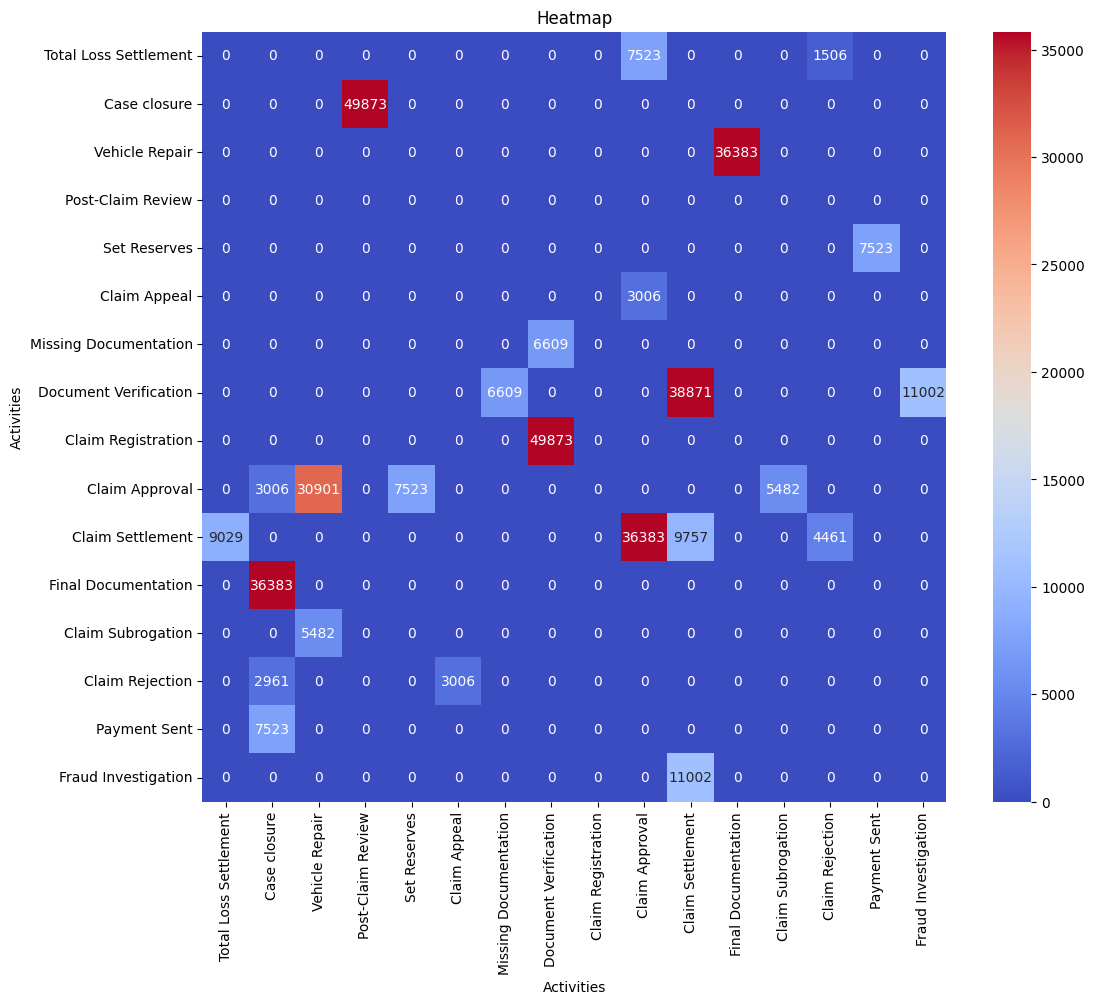

In [28]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_mtx, cmap="coolwarm", robust=True, annot=True, fmt="0000.0f")
plt.title("Heatmap")
plt.xlabel("Activities")
plt.ylabel("Activities")
plt.show()

# Alpha Miner

## Petri háló

In [29]:
log.head()

,Claim ID,Event,Timestamp,Channel,User Name,Claim Type,Damage Type,Accident Location,Car Model,Claim Amount,...,activity_key,timestamp_key,org:resource,case_id,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp
0,CLAIM0001,Claim Registration,2022-08-08 07:32:23+00:00,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,Claim Registration,2022-08-08 07:32:23+00:00,AROBINSON,CLAIM0001,CLAIM0001,Claim Registration,2022-08-08 07:32:23+00:00,0,0,2022-08-08 07:32:23+00:00
1,CLAIM0001,Document Verification,2022-08-08 12:32:23+00:00,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,Document Verification,2022-08-08 12:32:23+00:00,LCLARK,CLAIM0001,CLAIM0001,Document Verification,2022-08-08 12:32:23+00:00,1,0,2022-08-08 12:32:23+00:00
2,CLAIM0001,Missing Documentation,2022-08-09 00:32:23+00:00,Office,AROBINSON,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,Missing Documentation,2022-08-09 00:32:23+00:00,AROBINSON,CLAIM0001,CLAIM0001,Missing Documentation,2022-08-09 00:32:23+00:00,2,0,2022-08-09 00:32:23+00:00
3,CLAIM0001,Document Verification,2022-08-09 02:32:23+00:00,Office,CWHITE,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,Document Verification,2022-08-09 02:32:23+00:00,CWHITE,CLAIM0001,CLAIM0001,Document Verification,2022-08-09 02:32:23+00:00,3,0,2022-08-09 02:32:23+00:00
4,CLAIM0001,Claim Settlement,2022-08-09 14:32:23+00:00,Office,LCLARK,First Party,Hit-and-Run Accident,"San Diego, California",Fiat 500X Trekking AWD,1516,...,Claim Settlement,2022-08-09 14:32:23+00:00,LCLARK,CLAIM0001,CLAIM0001,Claim Settlement,2022-08-09 14:32:23+00:00,4,0,2022-08-09 14:32:23+00:00


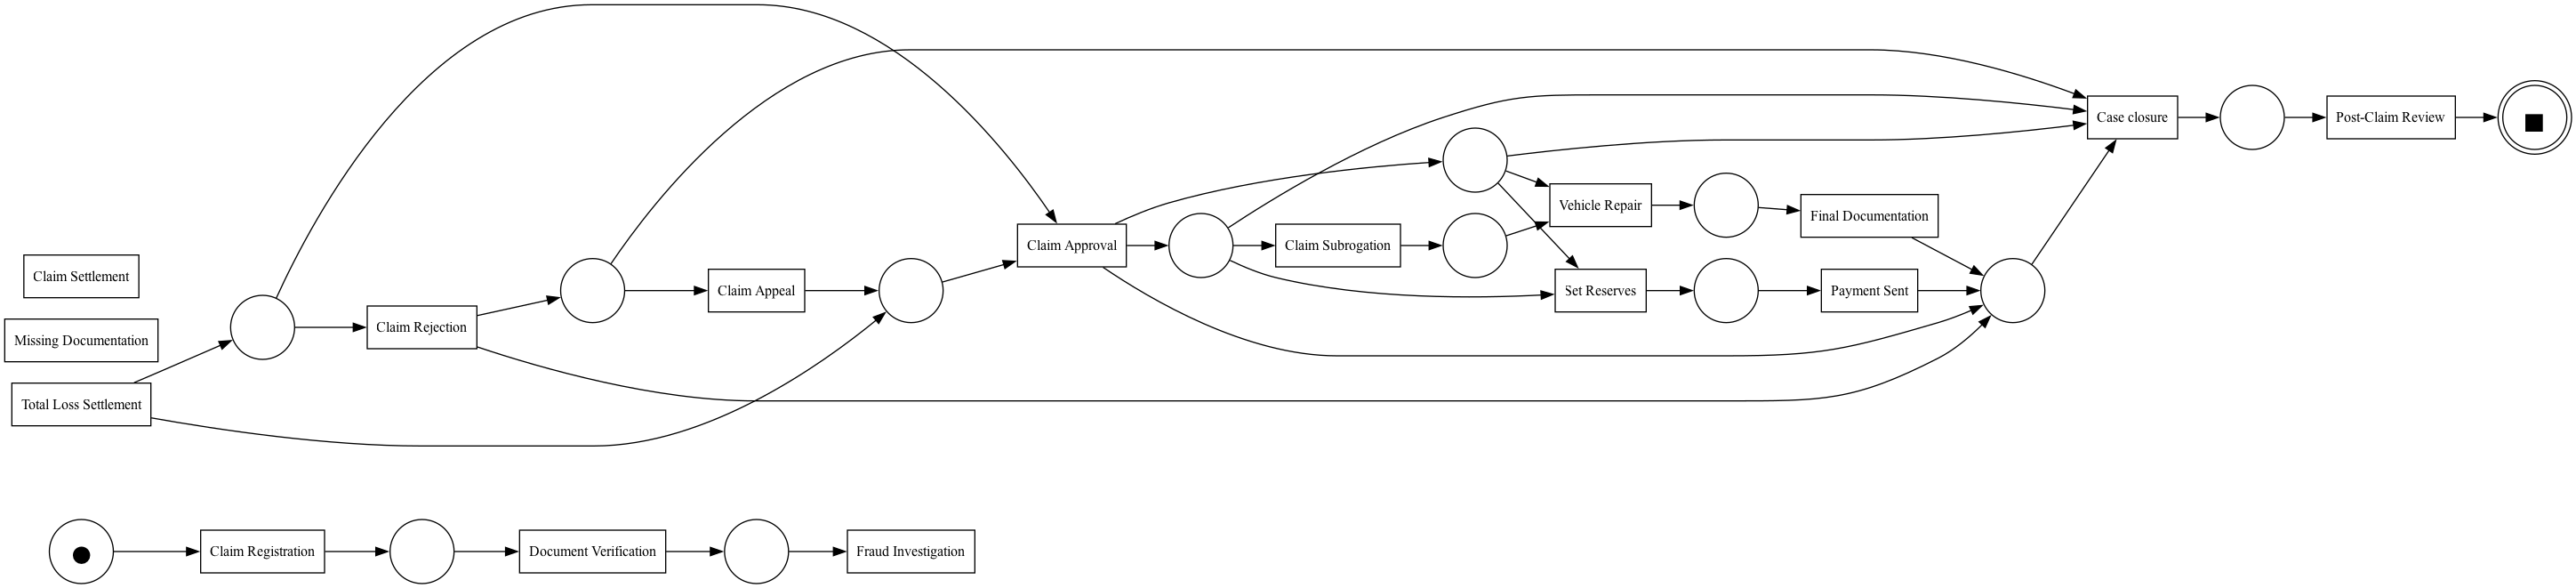

In [30]:
am_pnet, am_im, am_fm = pm4py.discover_petri_net_alpha(log)
pm4py.view_petri_net(am_pnet, am_im, am_fm, format='png')

Furcsa, hogy a folyamatnak ugyan van eleje és vége, de olyan, mintha két részre lenne szakadva. Ez nem tűnik megfelelő hálónak, olyan, mintha két külön folyamat lenne, ami egymással nincs kapcsolatban. A valóságban 11002 esetben került sor a Fraud Investigation-re és minden esetben Claim Settlement követte.

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 59.76it/s]


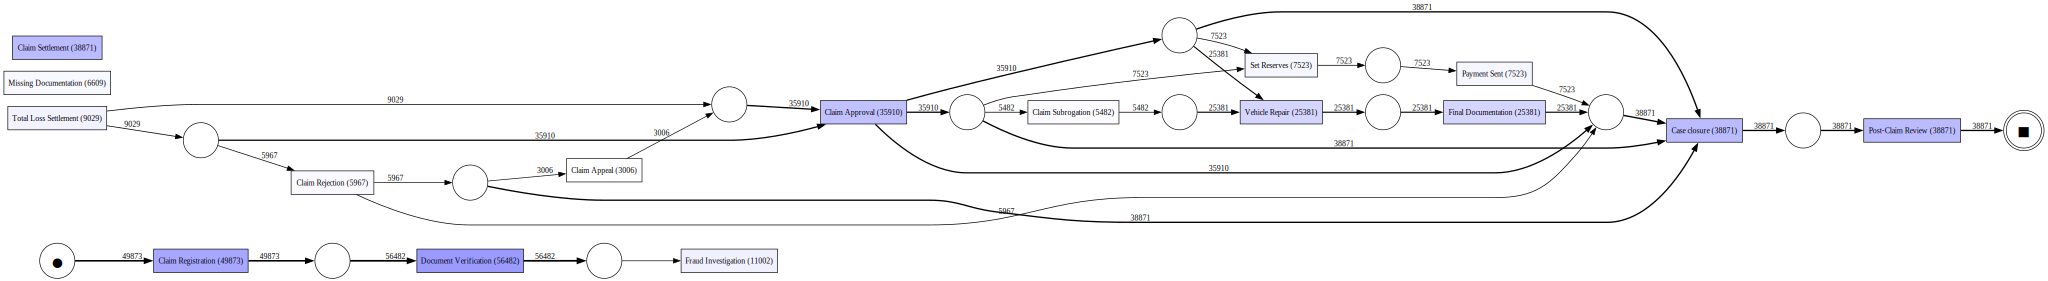

In [31]:
pn_visualizer.apply(am_pnet, am_im, am_fm, log, variant=pn_visualizer.Variants.FREQUENCY, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT:'png'})

## Footprint

In [32]:
#fp_net = footprints_discovery.apply(am_pnet, am_im, am_fm, variant=footprints_discovery.Variants.PETRI_REACH_GRAPH)

Sajnos ezt nem tudtam lefuttatni, több óra után sem ad eredményt. A furcsa Petri háló lehet az oka, de nem tudom biztosan.

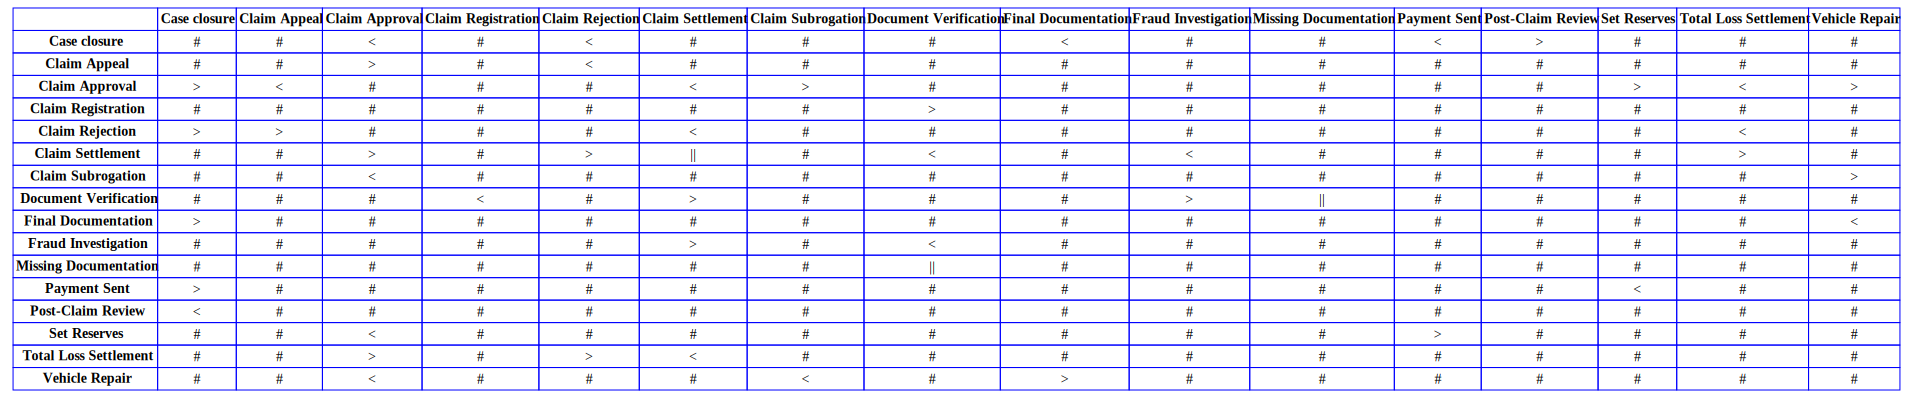

In [33]:
fp_visualizer.apply(fp_log, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT:'png'})

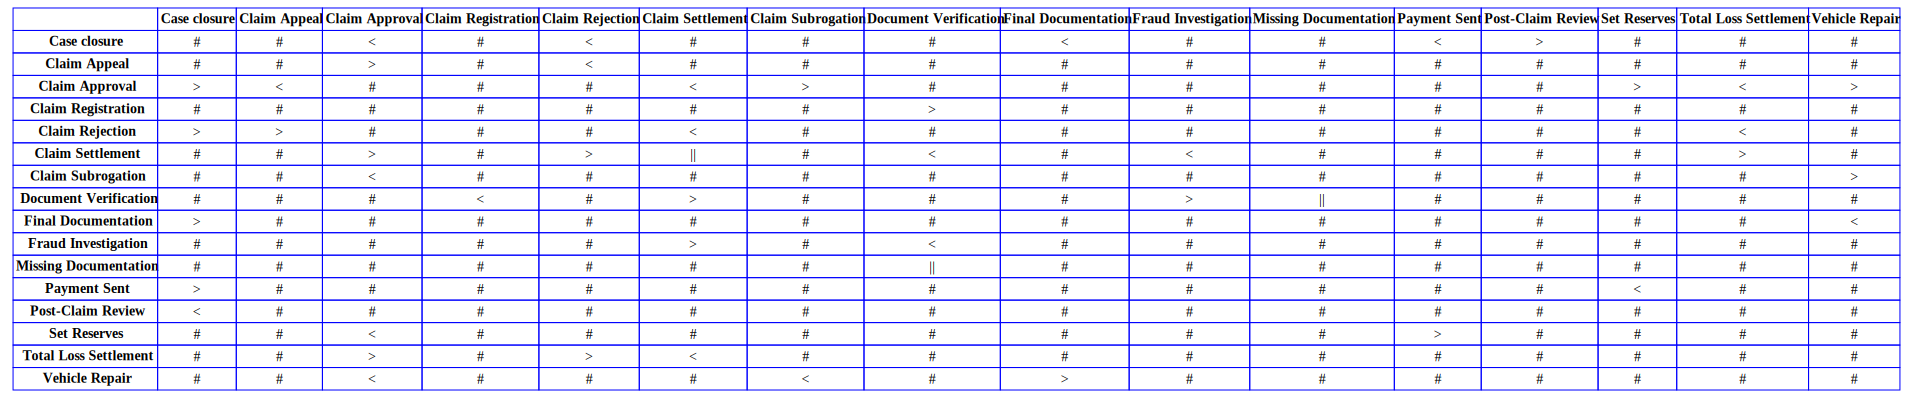

In [34]:
fp_net = footprints_discovery.apply(dfg, variant=footprints_discovery.Variants.DFG)
fp_visualizer.apply(fp_net, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT:'png'})

## Átmenetek átlagos ideje

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 70.14it/s]


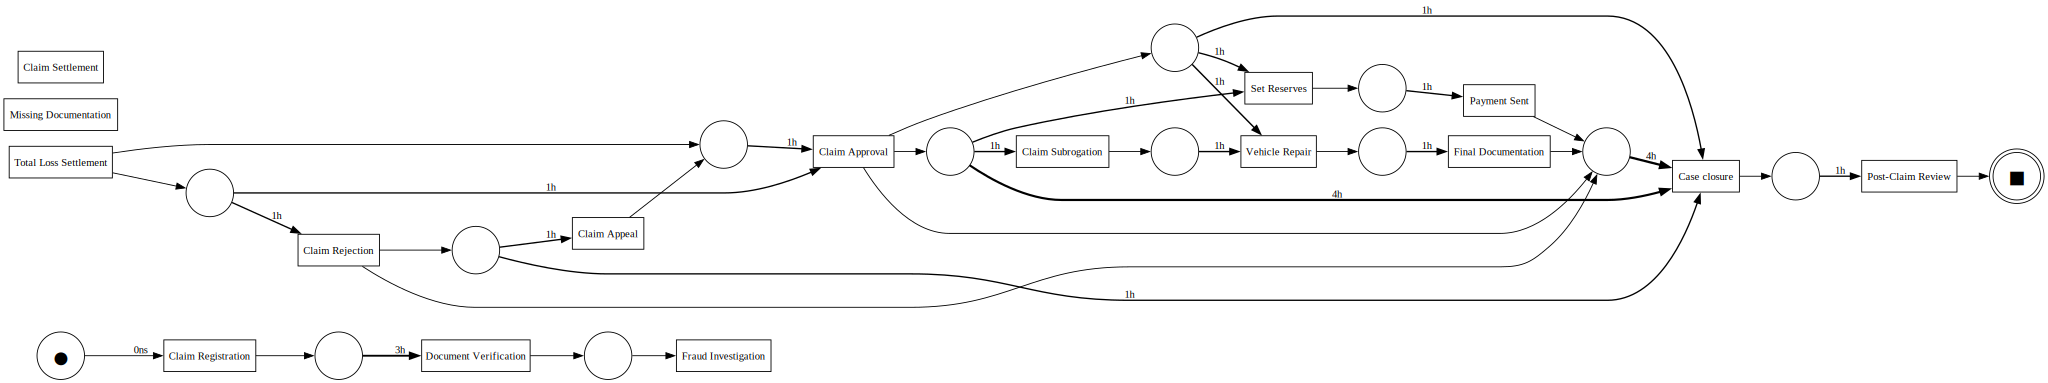

In [35]:
parameters = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT:'png'}
pn_visualizer.apply(am_pnet, am_im, am_fm, parameters=parameters, variant=pn_visualizer.Variants.PERFORMANCE, log=log)

## Evaluation

### Fitness
Mennyire írja le a modell a logot? Annak mérőszáma, hogy mennyire képes a modell reprodukálni a logot, mennyire fedi le a modell az eseménynaplóban megfigyelt viselkedést.

In [36]:
fitness_alpha = pm4py.fitness_token_based_replay(log, am_pnet, am_im, am_fm)
fitness_alpha['log_fitness']

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 43.41it/s]


0.7369977899738657

Ez talán az átlagos Alpha Miner eredményeknél alacsonyabbnak tűnik, de nem gondolom kimagaslóan rossznak.

### Precision
A log és a modell által leírt viselkedés eltérése, azt mutatja, hogy a modell mennyire kerüli a naplóban nem megfigyelt viselkedést.

In [37]:
precision_alpha = pm4py.precision_token_based_replay(log, am_pnet, am_im, am_fm)
precision_alpha

replaying log with TBR, completed traces :: 100%|██████████| 54/54 [00:00<00:00, 7472.04it/s]


0.33843007173332085

Ez a precision szerintem nagyon alacsonynak számít Alpha Miner esetén, hiszen pont ez az egyik erőssége. Azt jelenti hogy túl sok olyan működést enged meg a modell ami a logban nem szerepel.

### Generalization
A modell által leírt lehetséges viselkedés ami nem szerepel a logban, pl jövőbeni várható folyamat.

In [38]:
gen_alpha = generalization_evaluator.apply(log, am_pnet, am_im, am_fm)
gen_alpha

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 71.32it/s]


0.9914408327617552

Ez kimagaslóan jó eredménynek tűnik, de a precision eredményt látva nem feltétlenül hiszek ebben.

### Simplicity
Helyek átalgos kimenő-bejövő kapcsolatainak száma.

In [39]:
simp_alpha = simplicity_evaluator.apply(am_pnet)
simp_alpha

0.7142857142857143

Ez egy átlagos Alpha Miner mérőszámnak tűnik.

# Inductive Miner

## Petri háló

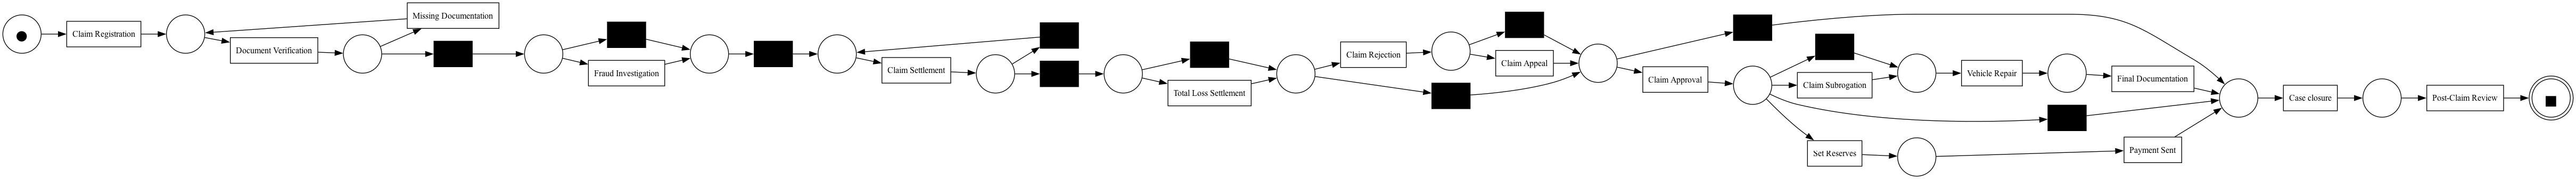

In [40]:
im_net, im_im, im_fm = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(im_net, im_im, im_fm, format='png')

Ezen a Petri hálón nekem sokkal inkább tűnik úgy, hogy lefedi a folyamatot és nincs is két részre szakadva. A Petri-hálóban a fekete téglalapok (telített átmenetek) általában láthatatlan átmeneteket jelölnek, amelyeket az Inductive Miner algoritmus vezet be a folyamatstruktúra modellezése során. Ezek az átmenetek nem megfigyelhető tevékenységek az eseménynaplóban, hanem a vezérlési folyamat logikáját segítik.

## Generált BPMN

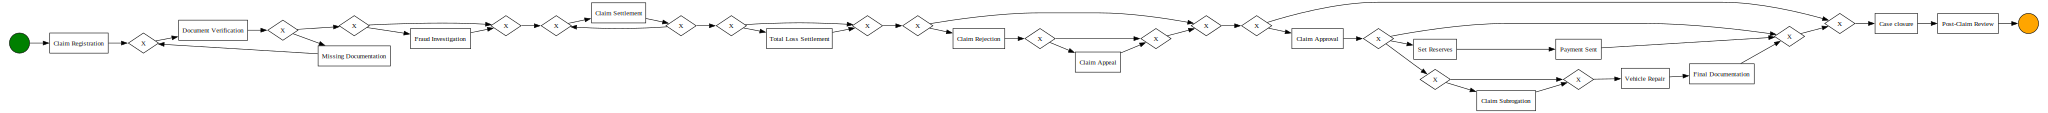

In [41]:
bpmn_graph = pm4py.discover_bpmn_inductive(log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
pm4py.visualization.bpmn.visualizer.apply(bpmn_graph)

A generált BPMN jónak tűnik, nem szakad meg sehol a folyamat, szépen végig követhető rajta hogy mi az események sorrendje.

## Evaluation

### Fitness

In [42]:
fitness_inductive = pm4py.fitness_token_based_replay(log, im_net, im_im, im_fm)
fitness_inductive['log_fitness']

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 71.74it/s]


1.0

A tökéletes fitness erdmény szerintem gyanúsan jó.

### Precision

In [43]:
precision_ind = pm4py.precision_token_based_replay(log, im_net, im_im, im_fm)
precision_ind

replaying log with TBR, completed traces :: 100%|██████████| 54/54 [00:00<00:00, 3571.20it/s]


0.6883037088525892

Ez jóval magasabb érték, mint az Alpha Miner esetében.

### Generalization

In [44]:
gen_ind = generalization_evaluator.apply(log, im_net, im_im, im_fm)
gen_ind

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 71.97it/s]


0.9912600402939487

Ez gyakorlatilag az Alpha Minerrel megegyező eredmény.

### Simplicity

In [45]:
simp_ind = simplicity_evaluator.apply(im_net)
simp_ind

0.7142857142857143

Ez az eredmény megegyzeik gyakorlatilag az Alpha Miner eredményével.

# Heuristic Miner

### Dependency Treshold

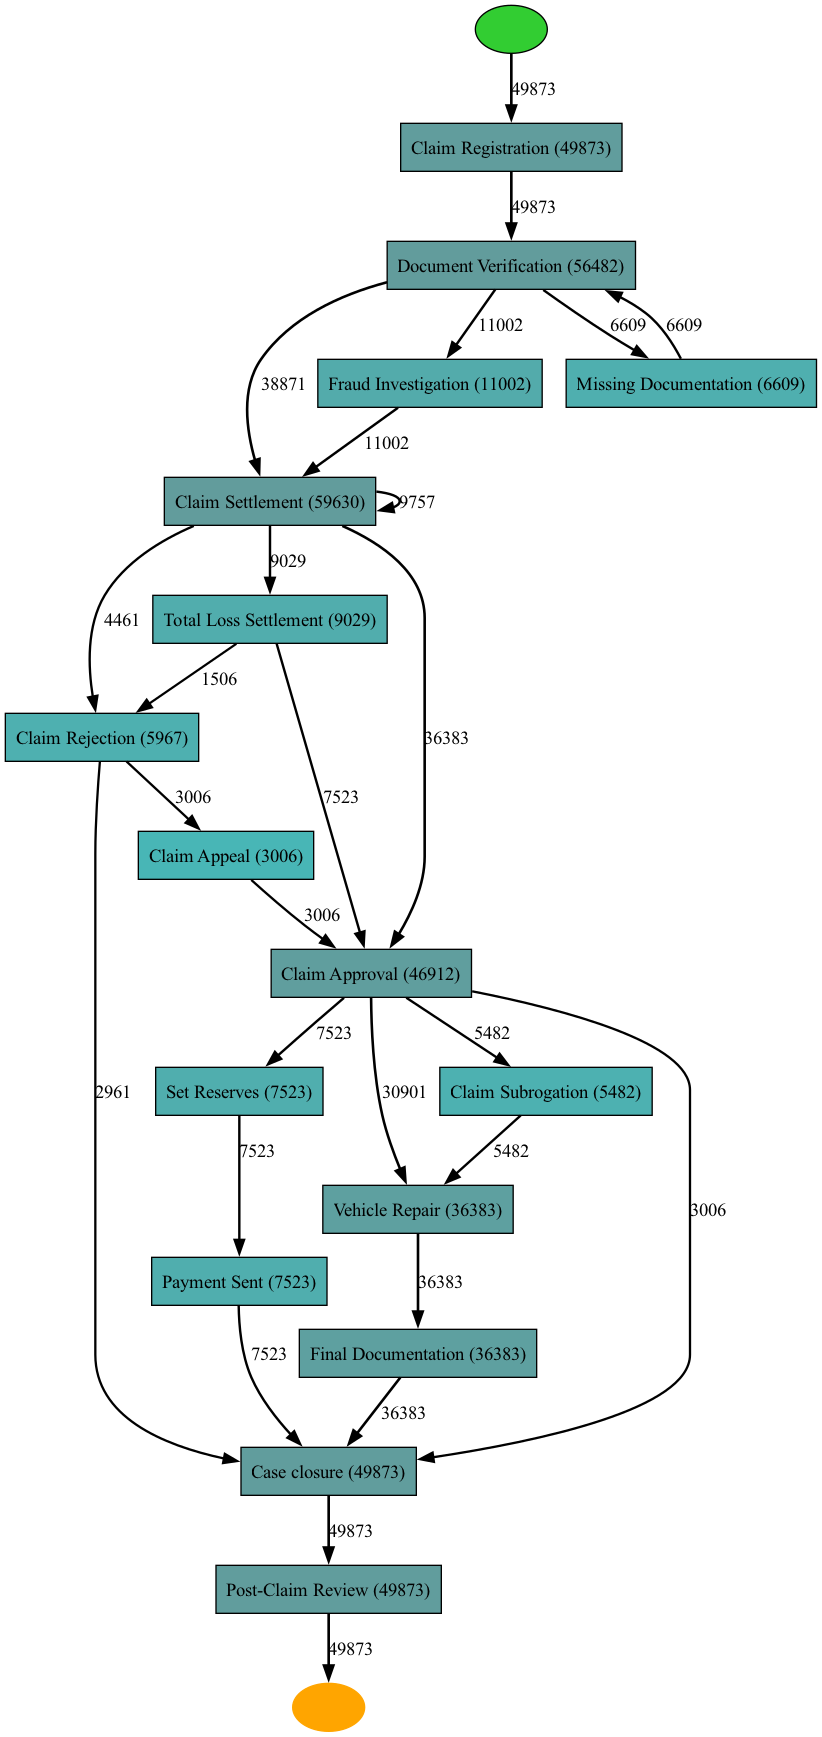

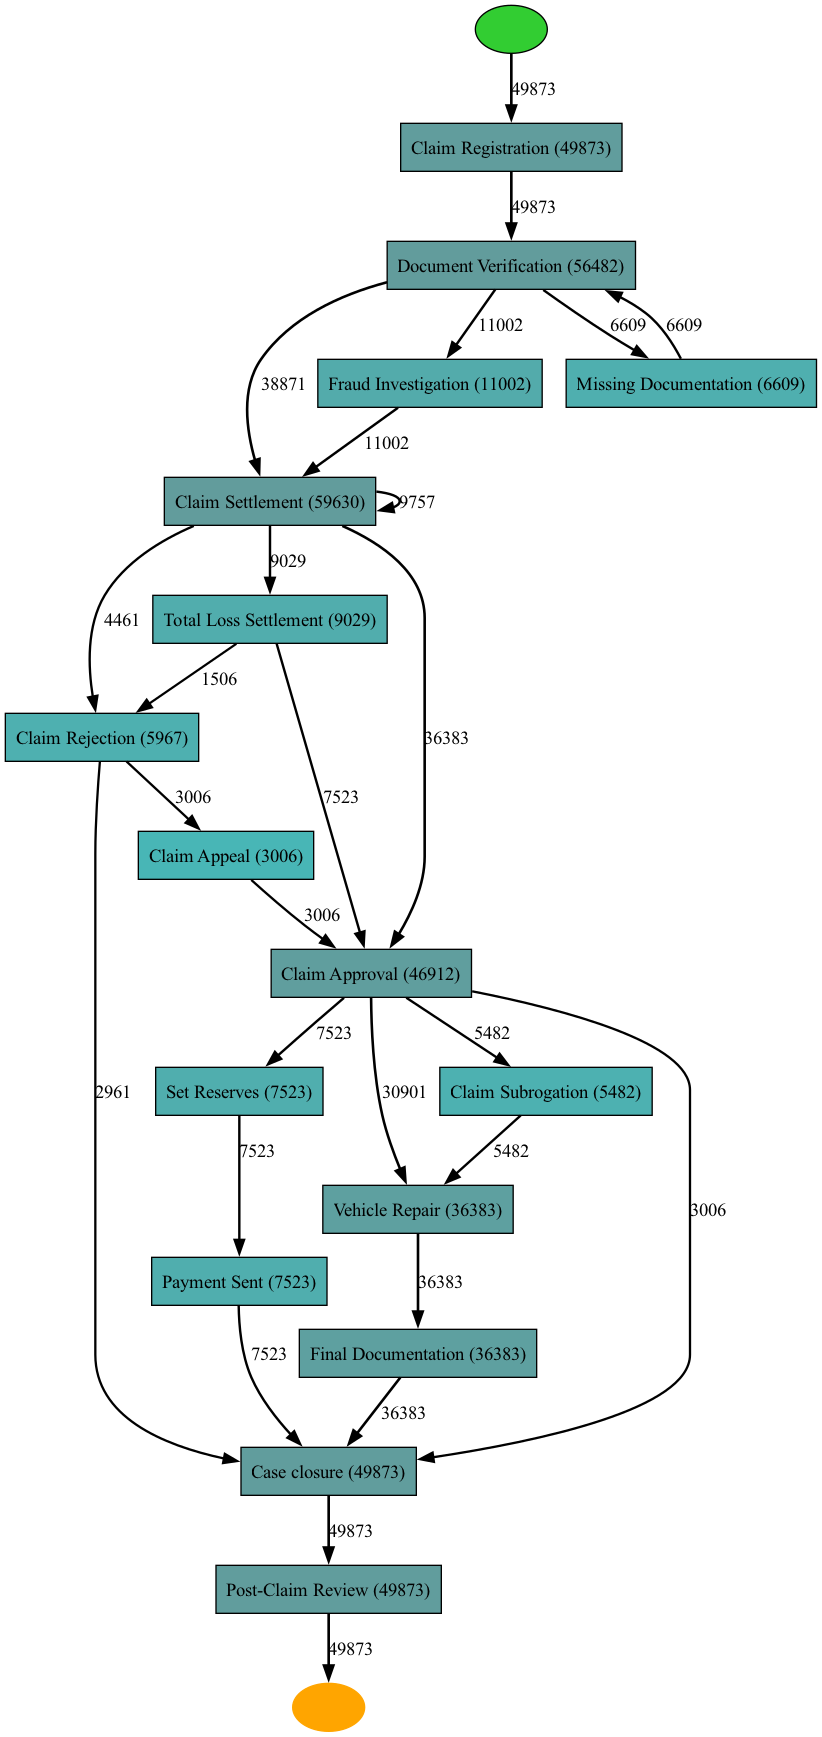

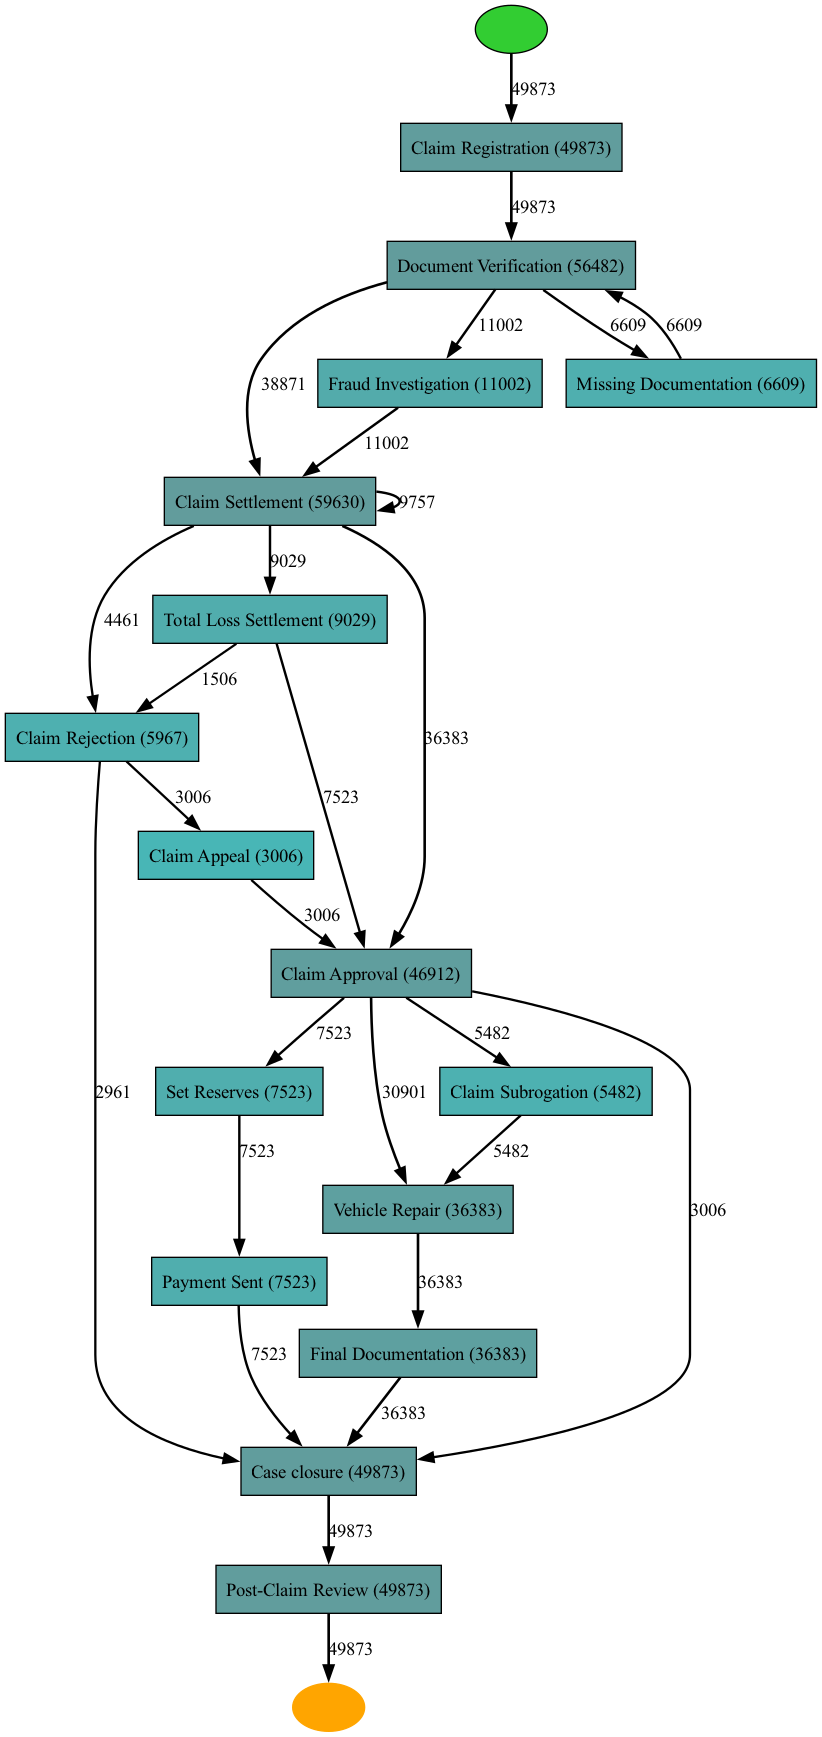

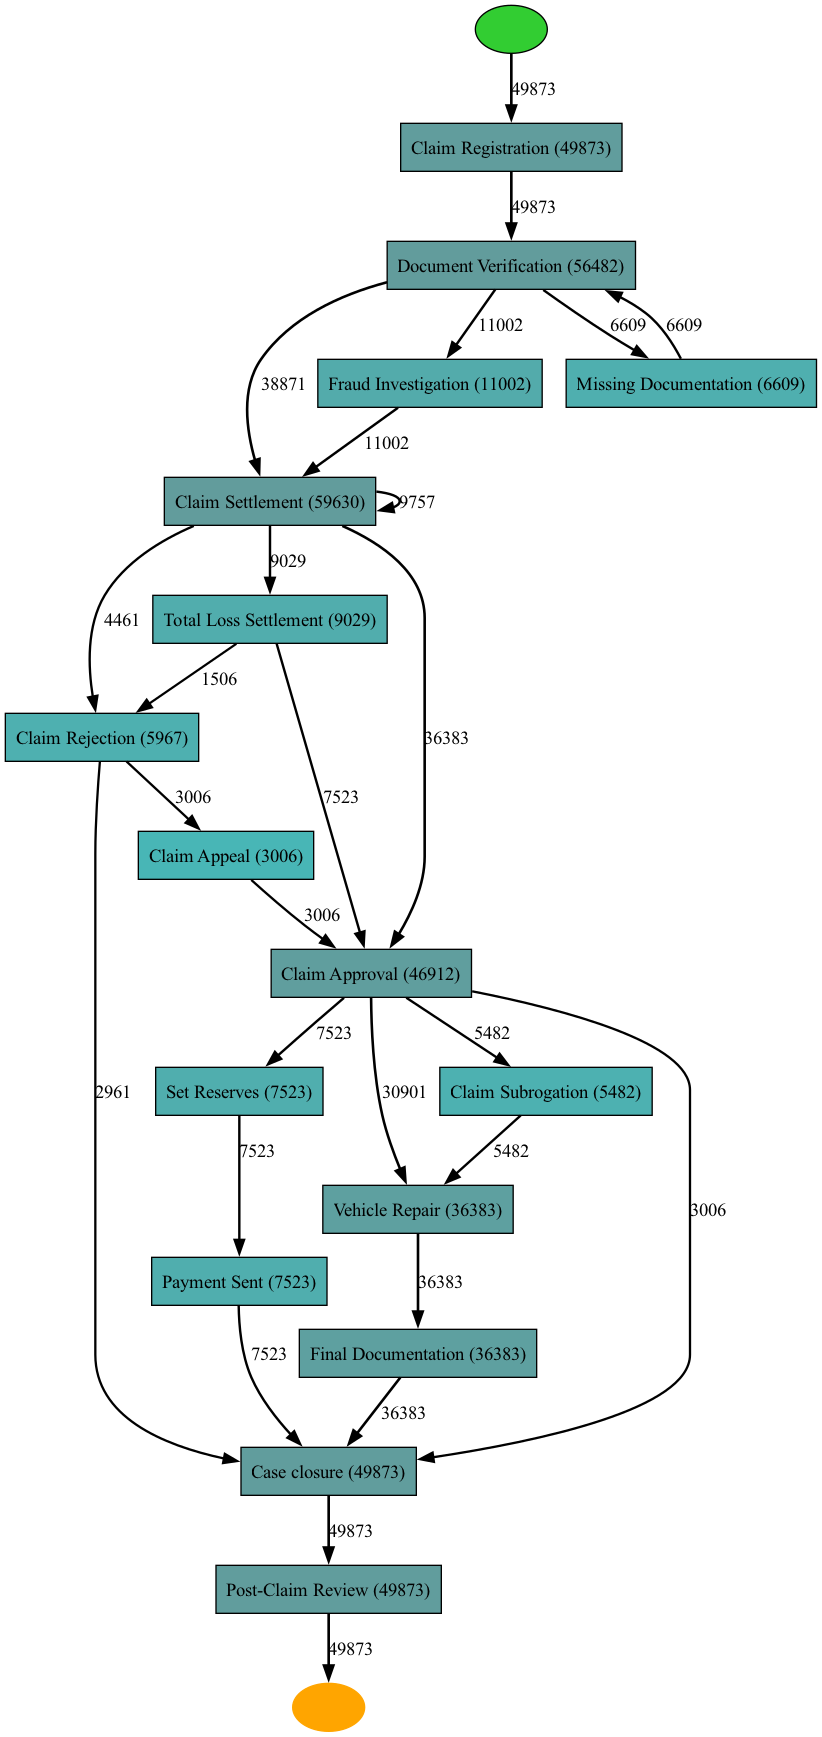

In [46]:
dthl = [0.25, 0.5, 0.75, 0.99]
for dth in dthl:
    hm_net = pm4py.discover_heuristics_net(log, dependency_threshold=dth)
    pm4py.view_heuristics_net(hm_net, format='png')

Ez egy nagyon szép ábra, áttekinthető és helyesek rajta a számok és a folyamat is.

Függetlenül a paraméter értékétél ugyan azt az ábrát kapjuk.

### Minimum Activity Count

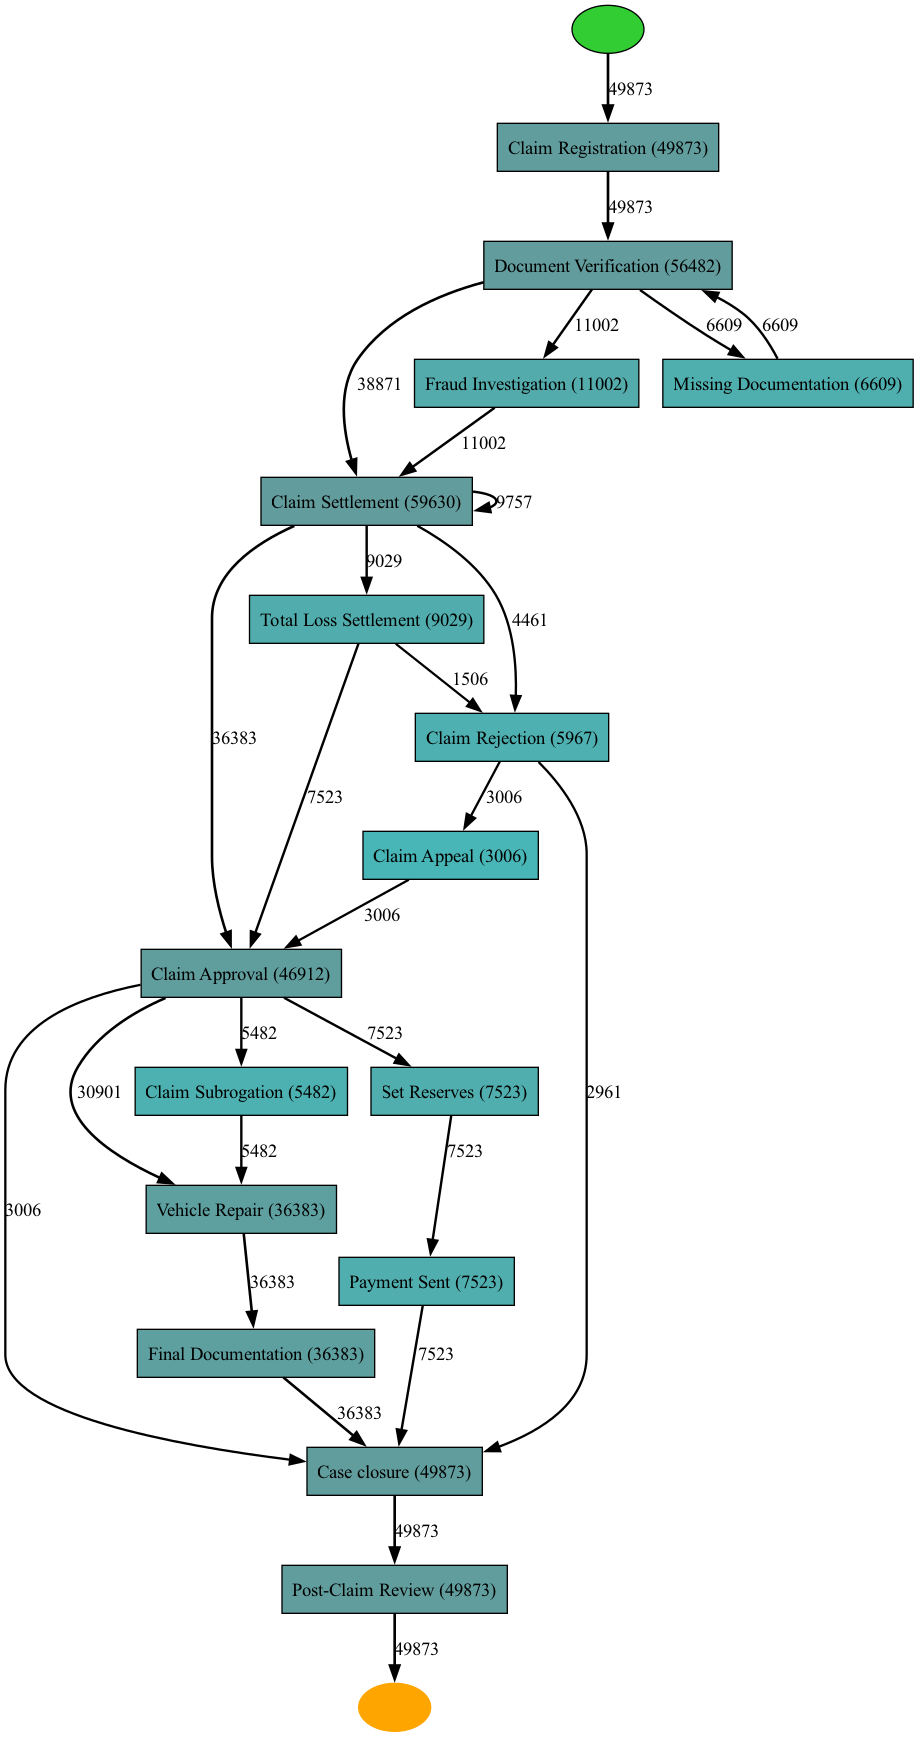

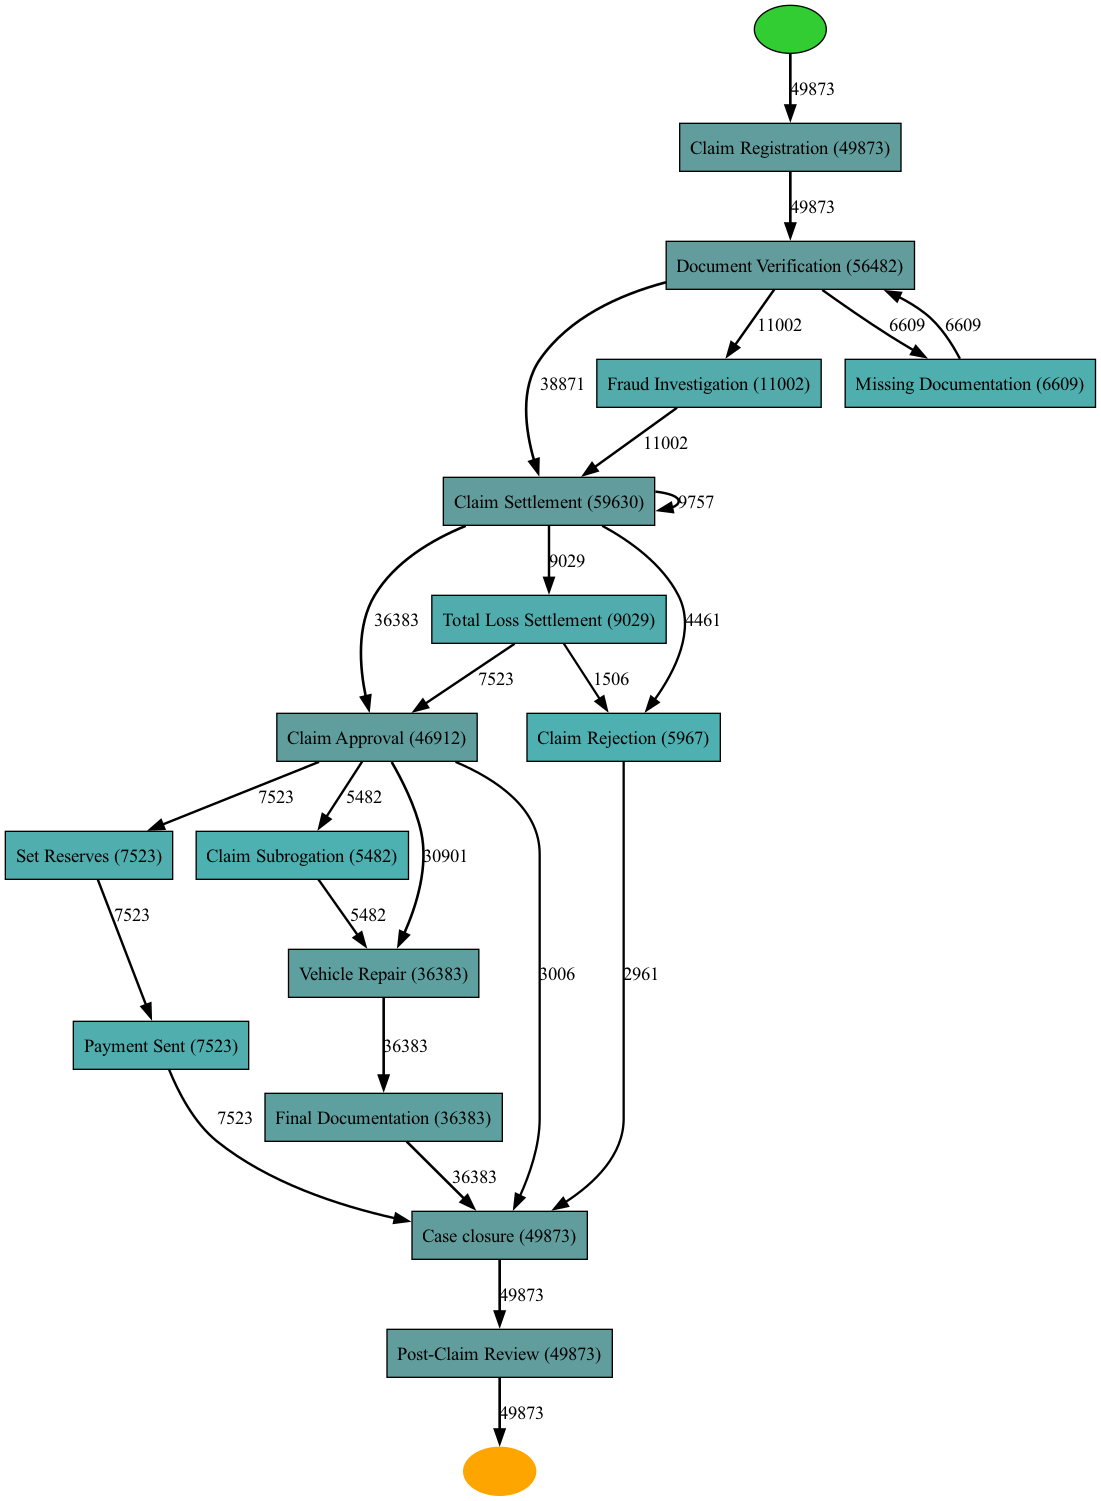

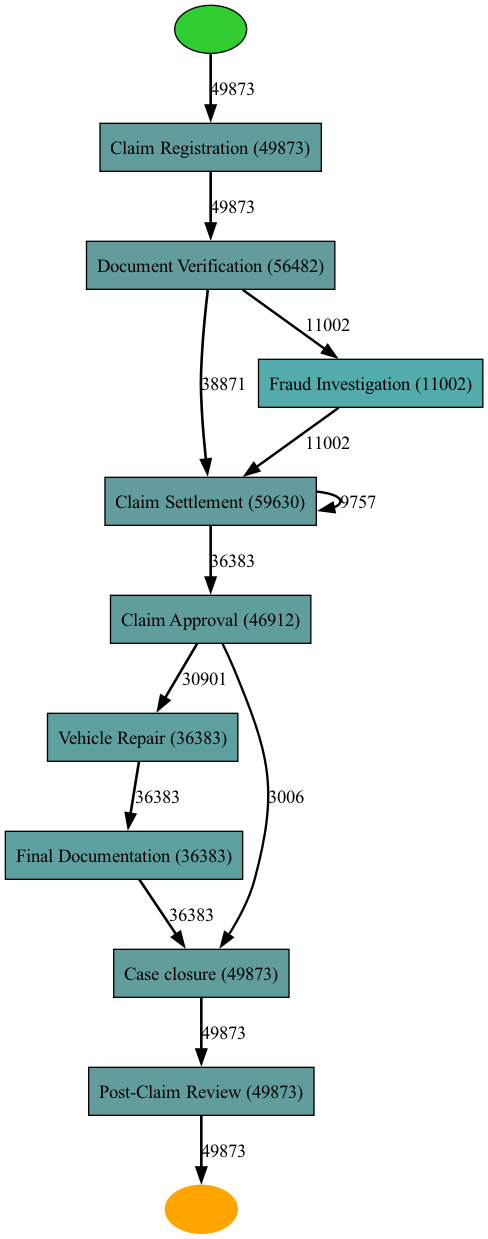

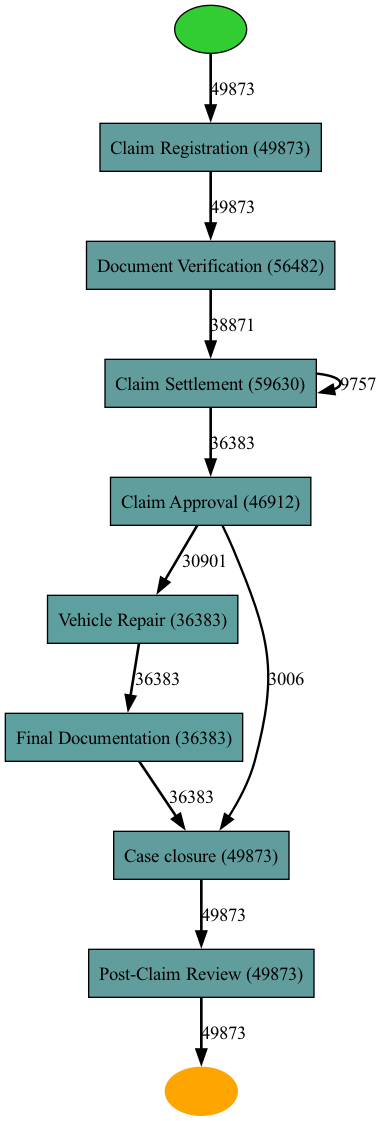

In [47]:
mac_list = [1000, 5000, 10000, 25000]
for mac in mac_list:
    heu_net_mac = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: mac})
    gviz = hn_visualizer.apply(heu_net_mac)
    hn_visualizer.view(gviz)

### Minimum Directly Folows

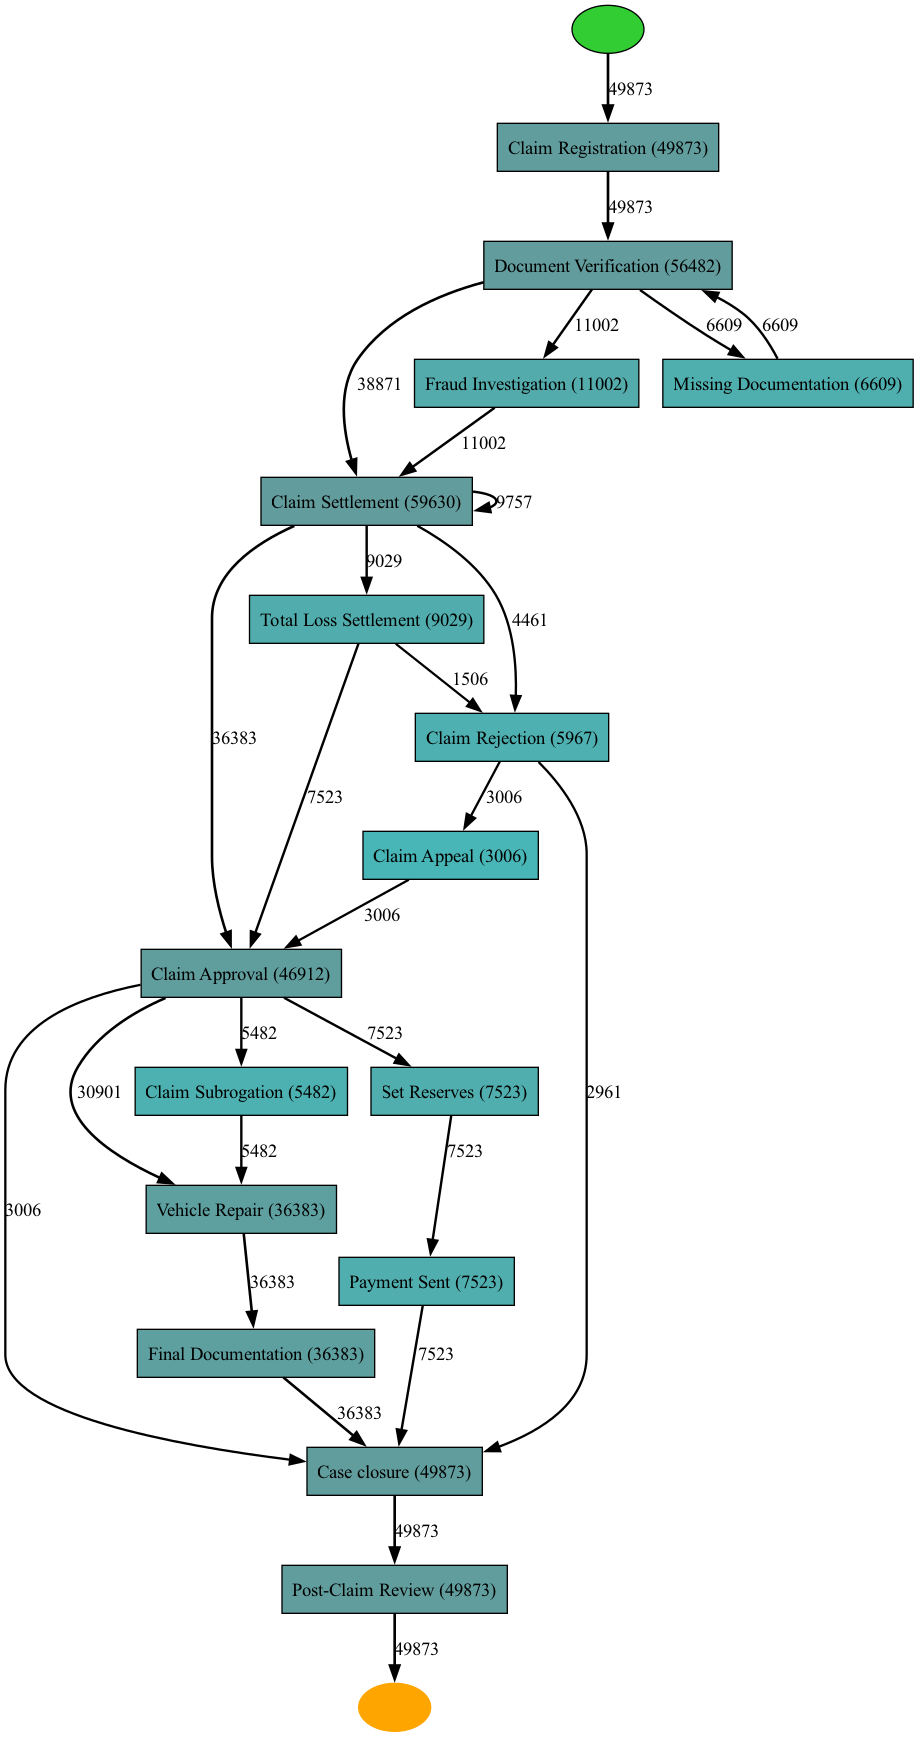

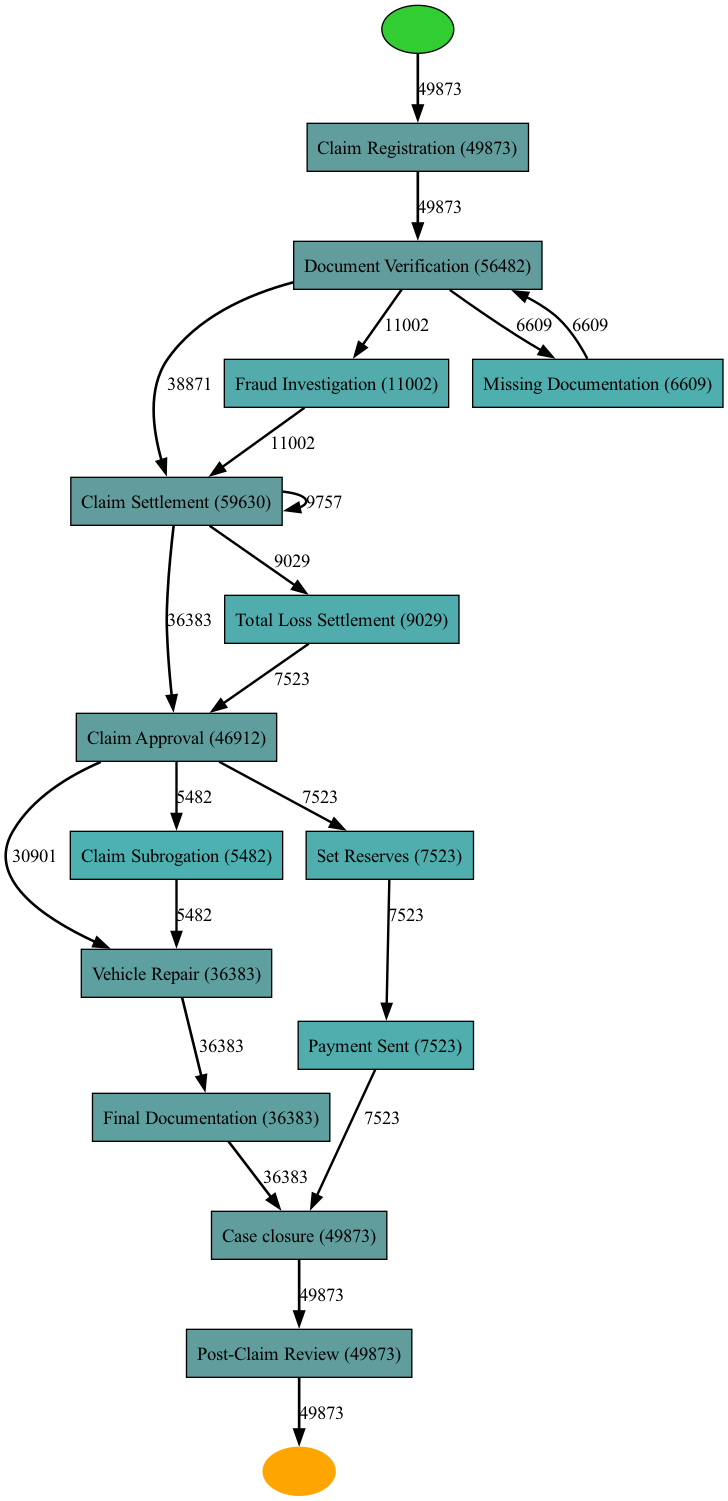

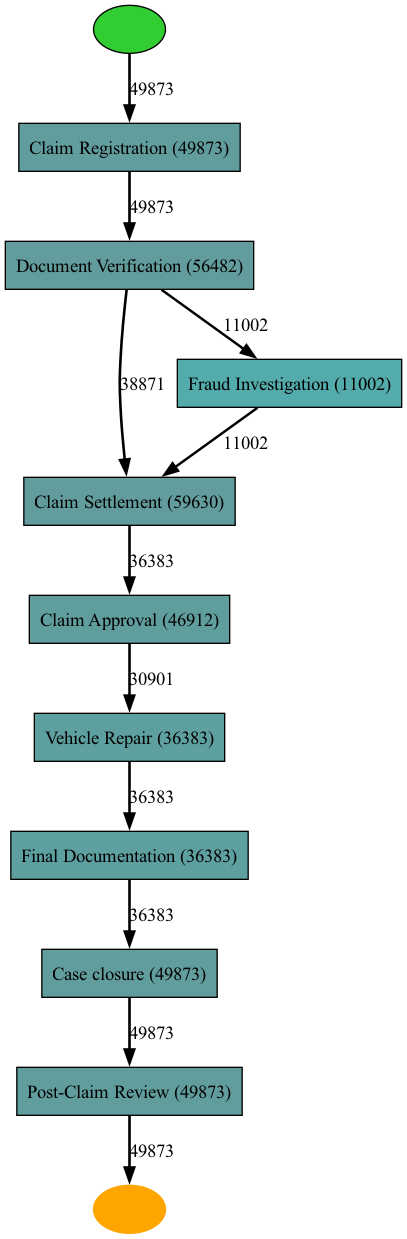

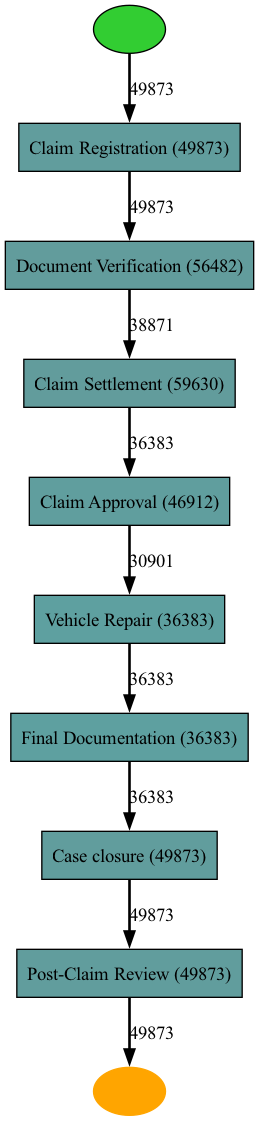

In [48]:
mdfg_list = [1000, 5000, 10000, 25000]
for mdfg in mdfg_list:
    heu_net_mdfg = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: mdfg})
    gviz = hn_visualizer.apply(heu_net_mdfg, parameters={'format':'png'})
    hn_visualizer.view(gviz)

Ezek is a vártnak megfelelően néznek ki, a mdfg növelésével egyre kevesebb elem jelenik meg a gráfon, ami a folyamatot egyre magasabb szinten az egyre fontosabb eventekre koncentrálva írja le.

## Petri háló

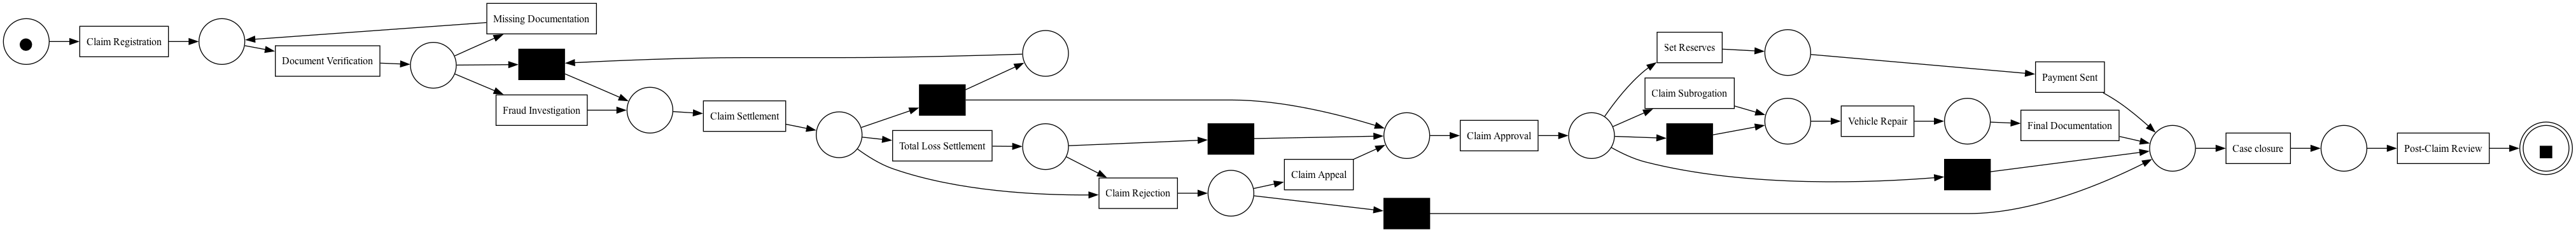

In [49]:
h_net, h_im, h_fm = pm4py.discover_petri_net_heuristics(log, dependency_threshold=0.5)
pm4py.view_petri_net(h_net, h_im, h_fm, format='png')

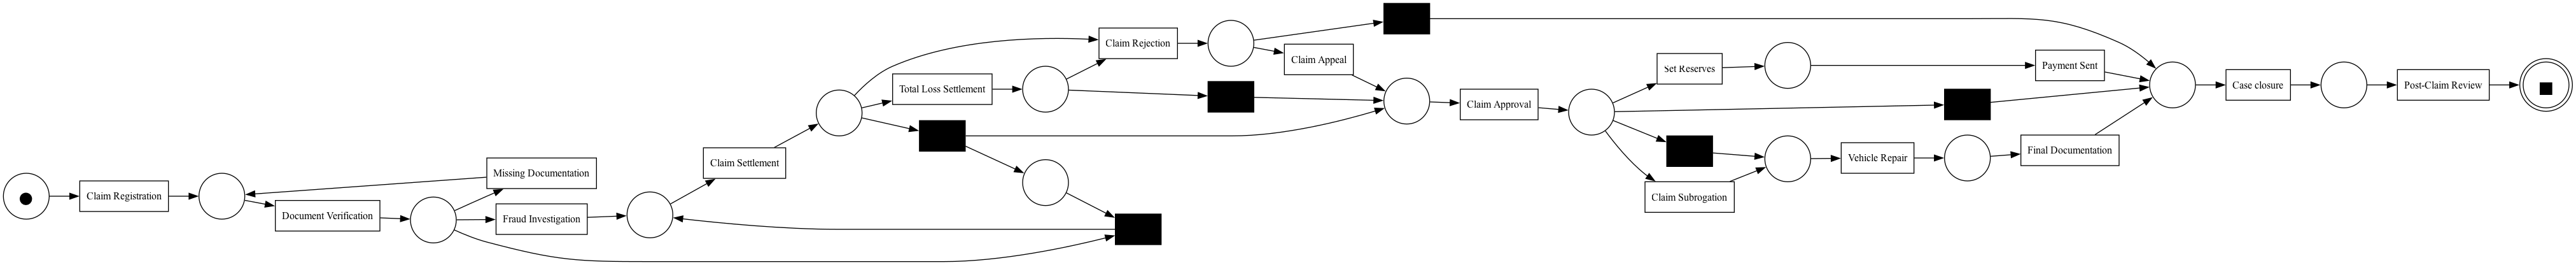

In [50]:
h_net, h_im, h_fm = pm4py.discover_petri_net_heuristics(log, dependency_threshold=0.9)
pm4py.view_petri_net(h_net, h_im, h_fm, format='png')

Nincs eltérés a generált hálóban.

## Evaluation

### Fitnemss

In [51]:
fitness_heur = pm4py.fitness_token_based_replay(log, h_net, h_im, h_fm)
fitness_heur['log_fitness']

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 69.46it/s]


0.8813561253792435

Az Alpha Miner-nél jobb, de az Indictive Miner-nél rosszabb eredmény.

### Precision

In [52]:
precision_heur = pm4py.precision_token_based_replay(log, h_net, h_im, h_fm)
precision_heur

replaying log with TBR, completed traces :: 100%|██████████| 54/54 [00:00<00:00, 6826.17it/s]


0.8857628412134231

Az eddigi legmagasabb precision.

### Generalization

In [53]:
gen_heur = generalization_evaluator.apply(log, h_net, h_im, h_fm)
gen_heur

replaying log with TBR, completed traces :: 100%|██████████| 11/11 [00:00<00:00, 53.25it/s]


0.9456449486273855

Az eddigi legalacsonyabb generalization.

### Simplicity

In [54]:
simp_heur = simplicity_evaluator.apply(h_net)
simp_heur

0.6785714285714285

Minimálisan alacsonyabb érték mint korábban a többi módszernél.

# Evaluation Comparision

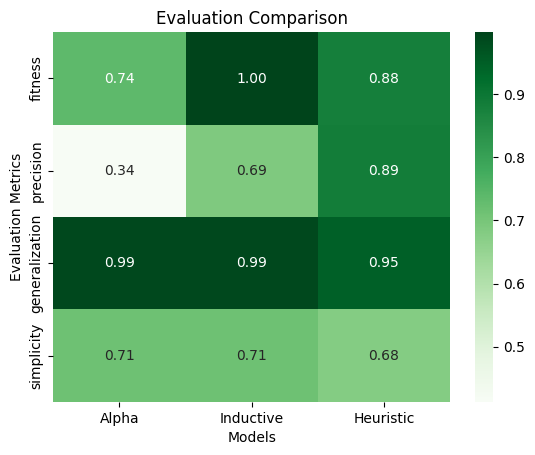

In [55]:
ev_comp = pd.DataFrame(columns=['Alpha','Inductive','Heuristic'], index=['fitness','precision','generalization','simplicity'])

ev_comp.at['fitness','Alpha'] = round(fitness_alpha['log_fitness'],3)
ev_comp.at['fitness','Inductive'] = round(fitness_inductive['log_fitness'],3)
ev_comp.at['fitness','Heuristic'] = round(fitness_heur['log_fitness'],3)

ev_comp.at['precision','Alpha'] = round(precision_alpha,3)
ev_comp.at['precision','Inductive'] = round(precision_ind,3)
ev_comp.at['precision','Heuristic'] = round(precision_heur,3)

ev_comp.at['generalization','Alpha'] = round(gen_alpha,3)
ev_comp.at['generalization','Inductive'] = round(gen_ind,3)
ev_comp.at['generalization','Heuristic'] = round(gen_heur,3)

ev_comp.at['simplicity','Alpha'] = round(simp_alpha,3)
ev_comp.at['simplicity','Inductive'] = round(simp_ind,3)
ev_comp.at['simplicity','Heuristic'] = round(simp_heur,3)

ev_comp = ev_comp[ev_comp.columns].astype(float)
sns.heatmap(ev_comp, cmap='Greens',robust=True,annot=True,fmt='.2f')
plt.title('Evaluation Comparison')
plt.ylabel('Evaluation Metrics')
plt.xlabel('Models')
plt.show()

# Frequent itemset and sequential pattern mining

In [56]:
cnames = hm_net.activities
codes = []
for i in range(0,len(cnames)): codes.append(i+1)
name_code_dict = dict(zip(cnames,codes))
code_name_dict = dict(zip(codes,cnames))

In [57]:
filt_log = log.loc[:,['case:concept:name','concept:name']]
filt_log['Code'] = ''
for i in range(0,len(filt_log)): filt_log.at[i,'Code'] = name_code_dict[filt_log.at[i,'concept:name']]
filt_log

,case:concept:name,concept:name,Code
0,CLAIM0001,Claim Registration,3
1,CLAIM0001,Document Verification,2
2,CLAIM0001,Missing Documentation,13
3,CLAIM0001,Document Verification,2
4,CLAIM0001,Claim Settlement,1
...,...,...,...
441545,CLAIM9999,Claim Subrogation,15
441546,CLAIM9999,Vehicle Repair,7
441547,CLAIM9999,Final Documentation,8
441548,CLAIM9999,Case closure,4


In [58]:
traces = list(log['case:concept:name'].values)
traces = list(dict.fromkeys(traces))

In [64]:
sequences = []
for trace in tqdm(traces):
    fl = filt_log[filt_log['case:concept:name']==trace]
    events = list(fl['Code'].values)
    sequences.append(events)
sequences

100%|██████████| 49873/49873 [09:24<00:00, 88.28it/s]


[[3, 2, 13, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 9, 1, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 9, 1, 6, 7, 8, 4, 5],
 [3, 2, 13, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 10, 6, 11, 12, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 10, 6, 11, 12, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 9, 1, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 15, 7, 8, 4, 5],
 [3, 2, 13, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 10, 6, 11, 12, 4, 5],
 [3, 2, 13, 2, 13, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 13, 2, 13, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 15, 7, 8, 4, 5],
 [3, 2, 1, 6, 15, 7, 8, 4, 5],
 [3, 2, 9, 1, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 10, 6, 11, 12, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 9, 1, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 6, 15, 7, 8, 4, 5],
 [3, 2, 1, 6, 7, 8, 4, 5],
 [3, 2, 1, 10, 6, 11

In [ ]:
with open('files/sequences.csv','w',newline='') as f:
    writer = csv.writer(f)
    writer.writerows(sequences)

In [ ]:
filename_in_spmf = 'files/sequences.csv'
filename_out_spmf = 'files/sequences_spmf.csv'
command = 'java -jar spmf.jar run Convert_a_sequence_database_to_SPMF_format '+filename_in_spmf+' '+filename_out_spmf+' CSV_INTEGER 100000'
os.system(command)

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
Sequence database converted.  Time spent for conversion = 53 ms.


0

## Frequent items mining

In [78]:
for minsup_fi in [0.02, 0.05, 0.1, 0.5]:
    filename_in_fi = 'files/sequences_spmf.csv'
    filename_out_fi = 'files/fis_Apr_'+str(int(minsup_fi*100))+'.csv'
    command = 'java -jar spmf.jar run Apriori '+filename_in_fi+' '+filename_out_fi+' '+str(minsup_fi)
    os.system(command)

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 184
 The algorithm stopped at size 5
 Frequent itemsets count : 51
 Maximum memory usage : 44.53599548339844 mb
 Total time ~ 128 ms
>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 183
 The algorithm stopped at size 5
 Frequent itemsets count : 49
 Maximum memory usage : 44.97198486328125 mb
 Total time ~ 133 ms
>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 164
 The algorithm stopped at size 5
 Frequent itemsets count : 45
 Maximum memory usage : 44.473548889160156 mb
 Total time ~ 108 ms
>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 55
 The algorithm stopped at size 2
 Frequent itemsets count : 10
 Maximum memory usage : 39.58061218261719 mb
 Total time ~ 71 ms


## Frequent closed itemset mining

In [79]:
for minsup_fci in [0.02, 0.05, 0.1, 0.5]:
    filename_in_fci = 'files/sequences_spmf.csv'
    filename_out_fci = 'files/fis_AprC_'+str(int(minsup_fci*100))+'.csv'
    command = 'java -jar spmf.jar run AprioriClose '+filename_in_fci+' '+filename_out_fci+' '+str(minsup_fci)  #The command needs to be a string
    os.system(command)

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 184
 The algorithm stopped at size 5, because there is no candidate
 Frequent closed itemsets count : 21
 Maximum memory usage : 44.681976318359375 mb
 Total time ~ 122 ms
>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 183
 The algorithm stopped at size 5, because there is no candidate
 Frequent closed itemsets count : 20
 Maximum memory usage : 45.141265869140625 mb
 Total time ~ 142 ms
>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 164
 The algorithm stopped at size 5, because there is no candidate
 Frequent closed itemsets count : 19
 Maximum memory usage : 44.760009765625 mb
 Total time ~ 126 ms
>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  APRIORI - STATS =============
 Candidates count : 55
 The algorithm stopp

## Frequent sequential pattern mining

In [80]:
for minsup_fsp in [0.2, 0.5, 0.75, 0.99]:
    filename_in_fsp = 'files/sequences_spmf.csv'
    filename_out_fsp = 'files/fsp_PrefixSpan_'+str(int(minsup_fsp*100))+'.csv'
    command = 'java -jar spmf.jar run PrefixSpan '+filename_in_fsp+' '+filename_out_fsp+' '+str(minsup_fsp)  #The command needs to be a string
    os.system(command)

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 312 ms
 Frequent sequences count : 511
 Max memory (mb) : 255.25354766845703
 minsup = 9975 sequences.
 Pattern count : 511

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 267 ms
 Frequent sequences count : 255
 Max memory (mb) : 160.57096099853516
 minsup = 24937 sequences.
 Pattern count : 255

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 156 ms
 Frequent sequences count : 63
 Max memory (mb) : 107.48023986816406
 minsup = 37405 sequences.
 Pattern count : 63

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 120 ms
 Frequent sequences count : 31
 Max memory (mb) : 64.72674560546875
 minsup = 49375 sequences.
 Pattern co

In [81]:
minsup_fsp = 0.2
min_pat_l = 2
max_pat_l = 4
gap = 2
filename_in_fsp = 'files/sequences_spmf.csv'
filename_out_fsp = 'files/fsp_CMSPAN_'+str(int(minsup_fsp*100))+'_minp_'+str(min_pat_l)+'_maxp_'+str(max_pat_l)+'_gap_'+str(gap)+'.csv'
command = 'java -jar spmf.jar run CM-SPAM '+filename_in_fsp+' '+filename_out_fsp+' '+str(minsup_fsp)+' '+str(min_pat_l)+' '+str(max_pat_l)+' "" '+str(gap)+' true'  #The command needs to be a string
os.system(command)

>/Users/tothi/pysrc/pemik/fmesfb/beadando/spmf.jar
=============  CM-SPAM v0.97 - STATISTICS =============
 Total time ~ 558 ms
 Frequent sequences count : 68
 Max memory (mb) : 194.9199523925781268
minsup 9975
Intersection count 147 



0